# Imports

In [205]:
import pandas as pd
import numpy as np
np.random.seed(2121)

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

from tensorflow.keras import utils
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from keras.models import Sequential
from tensorflow.keras.regularizers import l2

In [206]:
batpos = pd.read_csv('../data/batpos_feature_extracted.csv')

rdf_y_train = pd.read_csv('../data/rdf_y_train_preprocessed.csv')
rdf_X_test = pd.read_csv('../data/rdf_X_test_svr.csv')

ydf_y_train = pd.read_csv('../data/ydf_y_train_preprocessed.csv')
ydf_X_test = pd.read_csv('../data/ydf_X_test_rf.csv')

# DF prep

In [207]:
# set index and clear index name
for i in [rdf_y_train,rdf_X_test,ydf_y_train,ydf_X_test]:
    
    i.set_index('Unnamed: 0', inplace=True)
    i.index.name=None

In [208]:
rdf_X_test.rename(columns={'0':'runs_total_pg'}, inplace=True)
ydf_X_test.rename(columns={'0':'opprpg'}, inplace=True)

In [209]:
batpos = batpos[['waa_pg', 'player_id', 'name_common', 'age',
                   'waa_pg_1yr','waa_pg_2yr','waa_pg_3yr']]

In [210]:
batpos_test=pd.merge(pd.merge(rdf_X_test, ydf_X_test,
                              how='left', left_index=True, right_index=True,),
                     batpos,
                     how = 'left', left_index=True, right_index=True)

batpos_train=pd.merge(pd.merge(rdf_y_train, ydf_y_train,
                              how='left', left_index=True, right_index=True,),
                     batpos,
                     how = 'left', left_index=True, right_index=True)

In [211]:
target = 'waa_pg'

y_train = batpos_train[target]
X_train = batpos_train[[col for col in batpos_train.columns 
                        if col not in [target, 'player_id', 'name_common']]]


y_test = batpos_test[target]
X_test = batpos_test[[col for col in batpos_test.columns
                      if col not in [target, 'player_id', 'name_common']]]

In [212]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4555, 6), (1139, 6), (4555,), (1139,))

# Baseline

In [213]:
baseline_train = (3*X_train['waa_pg_1yr'] + 2*X_train['waa_pg_2yr'] +\
                 X_train['waa_pg_3yr'])/6

baseline_test = (3*X_test['waa_pg_1yr'] + 2*X_test['waa_pg_2yr'] +\
                X_test['waa_pg_3yr'])/6

In [214]:
r2_score(pd.concat([y_train,y_test]),
         pd.concat([baseline_train,baseline_test]))

0.2726753148207315

# Linear Regression

## Linear Regression (no regularization)

In [215]:
# initialize
lr = LinearRegression(n_jobs=-1)

# fit
lr.fit(X_train, y_train)

# score
print(f'Train Score: {lr.score(X_train, y_train):.4f}')
print(f'Test Score: {lr.score(X_test, y_test):.4f}')

Train Score: 0.9925
Test Score: 0.3477


## Linear Regression (Lasso)

In [216]:
lasso_cv = LassoCV(n_jobs=-1,
                       cv=5)

lasso_cv.fit(X_train, y_train)

print(f'Best Alpha: {lasso_cv.alpha_:.4f}')
print(f'Train Score: {lasso_cv.score(X_train, y_train):.4f}')
print(f'Test Score: {lasso_cv.score(X_test, y_test):.4f}')

Best Alpha: 0.0000
Train Score: 0.9924
Test Score: 0.3475


# Random Forest

In [217]:
rf = RandomForestRegressor(n_jobs=-1,
                           random_state=1212)

scores = cross_val_score(rf, X_train, y_train)
print(f'Train Score: {scores.mean():.4f}')


rf.fit(X_train, y_train)
print(f'Test Score: {rf.score(X_test, y_test):.4f}')

Train Score: 0.9957
Test Score: 0.3477


In [123]:
X_train

,runs_total_pg,opprpg,year_id,age,waa_pg_1yr,waa_pg_2yr,waa_pg_3yr
5416,-0.007087,4.70696,1979,28.0,0.015594,0.000724,0.006118
2253,-0.100000,4.96224,1997,32.0,-0.009054,0.001206,-0.005664
4487,0.154870,3.87468,1971,32.0,-0.015124,-0.030545,-0.015066
723,-0.026800,4.48127,1982,35.0,-0.004257,0.024500,0.005878
3970,-0.043625,4.28947,2012,29.0,0.024156,0.006538,0.012453
...,...,...,...,...,...,...,...
3213,0.349550,3.99035,2014,31.0,0.019528,0.000150,0.005520
1125,0.059359,4.37636,1977,29.0,0.015789,0.015143,0.021750
2626,-0.229900,3.86230,1992,31.0,0.008590,0.002013,0.031438
1690,-0.201624,4.37636,1977,26.0,-0.013893,-0.010066,0.003223


In [124]:
param_grid = {
    'max_features': [3,5,7],
    'max_depth': [3,5,10,None],
    'min_samples_leaf': [1,2,3,5]}

In [125]:
rf_gs = RandomForestRegressor(n_jobs=-1,
                           n_estimators=100,
                           random_state=1212)

In [126]:
gs = GridSearchCV(rf_gs, param_grid, verbose=3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END max_depth=3, max_features=3, min_samples_leaf=1;, score=0.861 total time=   0.1s
[CV 2/5] END max_depth=3, max_features=3, min_samples_leaf=1;, score=0.840 total time=   0.2s
[CV 3/5] END max_depth=3, max_features=3, min_samples_leaf=1;, score=0.850 total time=   0.2s
[CV 4/5] END max_depth=3, max_features=3, min_samples_leaf=1;, score=0.850 total time=   0.1s
[CV 5/5] END max_depth=3, max_features=3, min_samples_leaf=1;, score=0.843 total time=   0.2s
[CV 1/5] END max_depth=3, max_features=3, min_samples_leaf=2;, score=0.861 total time=   0.1s
[CV 2/5] END max_depth=3, max_features=3, min_samples_leaf=2;, score=0.840 total time=   0.1s
[CV 3/5] END max_depth=3, max_features=3, min_samples_leaf=2;, score=0.850 total time=   0.1s
[CV 4/5] END max_depth=3, max_features=3, min_samples_leaf=2;, score=0.850 total time=   0.1s
[CV 5/5] END max_depth=3, max_features=3, min_samples_leaf=2;, score=0.843 total time=   0.4

[CV 3/5] END max_depth=5, max_features=5, min_samples_leaf=2;, score=0.989 total time=   0.2s
[CV 4/5] END max_depth=5, max_features=5, min_samples_leaf=2;, score=0.991 total time=   0.2s
[CV 5/5] END max_depth=5, max_features=5, min_samples_leaf=2;, score=0.985 total time=   0.2s
[CV 1/5] END max_depth=5, max_features=5, min_samples_leaf=3;, score=0.991 total time=   0.2s
[CV 2/5] END max_depth=5, max_features=5, min_samples_leaf=3;, score=0.988 total time=   0.2s
[CV 3/5] END max_depth=5, max_features=5, min_samples_leaf=3;, score=0.989 total time=   0.2s
[CV 4/5] END max_depth=5, max_features=5, min_samples_leaf=3;, score=0.991 total time=   0.2s
[CV 5/5] END max_depth=5, max_features=5, min_samples_leaf=3;, score=0.985 total time=   0.2s
[CV 1/5] END max_depth=5, max_features=5, min_samples_leaf=5;, score=0.991 total time=   0.2s
[CV 2/5] END max_depth=5, max_features=5, min_samples_leaf=5;, score=0.988 total time=   0.2s
[CV 3/5] END max_depth=5, max_features=5, min_samples_leaf=5

[CV 5/5] END max_depth=10, max_features=7, min_samples_leaf=3;, score=0.995 total time=   0.3s
[CV 1/5] END max_depth=10, max_features=7, min_samples_leaf=5;, score=0.996 total time=   0.3s
[CV 2/5] END max_depth=10, max_features=7, min_samples_leaf=5;, score=0.996 total time=   0.3s
[CV 3/5] END max_depth=10, max_features=7, min_samples_leaf=5;, score=0.996 total time=   0.3s
[CV 4/5] END max_depth=10, max_features=7, min_samples_leaf=5;, score=0.996 total time=   0.3s
[CV 5/5] END max_depth=10, max_features=7, min_samples_leaf=5;, score=0.994 total time=   0.3s
[CV 1/5] END max_depth=None, max_features=3, min_samples_leaf=1;, score=0.993 total time=   0.3s
[CV 2/5] END max_depth=None, max_features=3, min_samples_leaf=1;, score=0.988 total time=   0.3s
[CV 3/5] END max_depth=None, max_features=3, min_samples_leaf=1;, score=0.991 total time=   0.3s
[CV 4/5] END max_depth=None, max_features=3, min_samples_leaf=1;, score=0.991 total time=   0.3s
[CV 5/5] END max_depth=None, max_features=

GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=1212),
             param_grid={'max_depth': [3, 5, 10, None],
                         'max_features': [3, 5, 7],
                         'min_samples_leaf': [1, 2, 3, 5]},
             verbose=3)

In [127]:
gs.best_params_

{'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1}

In [129]:
gs.best_score_

0.9959217751871524

In [218]:
rf = RandomForestRegressor(n_jobs=-1,
                           random_state=1212,
                           n_estimators=1000)

scores = cross_val_score(rf, X_train, y_train)
print(f'Train Score: {scores.mean():.4f}')


rf.fit(X_train, y_train)
print(f'Test Score: {rf.score(X_test, y_test):.4f}')

Train Score: 0.9958
Test Score: 0.3478


# Extra Trees

In [134]:
et = ExtraTreesRegressor(n_jobs=-1,
                           random_state=1212,
                           n_estimators=100,)

scores = cross_val_score(et, X_train, y_train)
print(f'Train Score: {scores.mean():.4f}')


et.fit(X_train, y_train)
print(f'Test Score: {et.score(X_test, y_test):.4f}')

Train Score: 0.9963
Test Score: 0.3472


In [135]:
es_gs = ExtraTreesRegressor(n_jobs=-1,
                            n_estimators=100,
                            random_state=1212)

egs = GridSearchCV(es_gs, param_grid, verbose=3)
egs.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END max_depth=3, max_features=3, min_samples_leaf=1;, score=0.615 total time=   0.1s
[CV 2/5] END max_depth=3, max_features=3, min_samples_leaf=1;, score=0.614 total time=   0.1s
[CV 3/5] END max_depth=3, max_features=3, min_samples_leaf=1;, score=0.606 total time=   0.2s
[CV 4/5] END max_depth=3, max_features=3, min_samples_leaf=1;, score=0.610 total time=   0.1s
[CV 5/5] END max_depth=3, max_features=3, min_samples_leaf=1;, score=0.638 total time=   0.1s
[CV 1/5] END max_depth=3, max_features=3, min_samples_leaf=2;, score=0.609 total time=   0.1s
[CV 2/5] END max_depth=3, max_features=3, min_samples_leaf=2;, score=0.626 total time=   0.2s
[CV 3/5] END max_depth=3, max_features=3, min_samples_leaf=2;, score=0.614 total time=   0.1s
[CV 4/5] END max_depth=3, max_features=3, min_samples_leaf=2;, score=0.617 total time=   0.1s
[CV 5/5] END max_depth=3, max_features=3, min_samples_leaf=2;, score=0.632 total time=   0.1

[CV 3/5] END max_depth=5, max_features=5, min_samples_leaf=2;, score=0.896 total time=   0.1s
[CV 4/5] END max_depth=5, max_features=5, min_samples_leaf=2;, score=0.909 total time=   0.1s
[CV 5/5] END max_depth=5, max_features=5, min_samples_leaf=2;, score=0.906 total time=   0.1s
[CV 1/5] END max_depth=5, max_features=5, min_samples_leaf=3;, score=0.895 total time=   0.1s
[CV 2/5] END max_depth=5, max_features=5, min_samples_leaf=3;, score=0.908 total time=   0.1s
[CV 3/5] END max_depth=5, max_features=5, min_samples_leaf=3;, score=0.898 total time=   0.1s
[CV 4/5] END max_depth=5, max_features=5, min_samples_leaf=3;, score=0.900 total time=   0.1s
[CV 5/5] END max_depth=5, max_features=5, min_samples_leaf=3;, score=0.902 total time=   0.1s
[CV 1/5] END max_depth=5, max_features=5, min_samples_leaf=5;, score=0.894 total time=   0.1s
[CV 2/5] END max_depth=5, max_features=5, min_samples_leaf=5;, score=0.883 total time=   0.2s
[CV 3/5] END max_depth=5, max_features=5, min_samples_leaf=5

[CV 5/5] END max_depth=10, max_features=7, min_samples_leaf=3;, score=0.993 total time=   0.2s
[CV 1/5] END max_depth=10, max_features=7, min_samples_leaf=5;, score=0.995 total time=   0.1s
[CV 2/5] END max_depth=10, max_features=7, min_samples_leaf=5;, score=0.993 total time=   0.2s
[CV 3/5] END max_depth=10, max_features=7, min_samples_leaf=5;, score=0.994 total time=   0.2s
[CV 4/5] END max_depth=10, max_features=7, min_samples_leaf=5;, score=0.994 total time=   0.2s
[CV 5/5] END max_depth=10, max_features=7, min_samples_leaf=5;, score=0.992 total time=   0.6s
[CV 1/5] END max_depth=None, max_features=3, min_samples_leaf=1;, score=0.992 total time=   0.3s
[CV 2/5] END max_depth=None, max_features=3, min_samples_leaf=1;, score=0.990 total time=   0.3s
[CV 3/5] END max_depth=None, max_features=3, min_samples_leaf=1;, score=0.991 total time=   0.3s
[CV 4/5] END max_depth=None, max_features=3, min_samples_leaf=1;, score=0.989 total time=   0.3s
[CV 5/5] END max_depth=None, max_features=

GridSearchCV(estimator=ExtraTreesRegressor(n_jobs=-1, random_state=1212),
             param_grid={'max_depth': [3, 5, 10, None],
                         'max_features': [3, 5, 7],
                         'min_samples_leaf': [1, 2, 3, 5]},
             verbose=3)

In [136]:
egs.best_params_

{'max_depth': None, 'max_features': 7, 'min_samples_leaf': 1}

In [137]:
gs.best_score_

0.9959217751871524

In [138]:
et = ExtraTreesRegressor(n_jobs=-1,
                           random_state=1212,
                           n_estimators=1000,)

scores = cross_val_score(et, X_train, y_train)
print(f'Train Score: {scores.mean():.4f}')


et.fit(X_train, y_train)
print(f'Test Score: {et.score(X_test, y_test):.4f}')

Train Score: 0.9963
Test Score: 0.3473


# SVM

In [139]:
svr = SVR()

scores = cross_val_score(svr, X_train, y_train)
# score
print(f'Train Score: {scores.mean():.4f}')

svr.fit(X_train, y_train)
print(f'Test Score: {svr.score(X_test,y_test):.4f}')

Train Score: -0.2046
Test Score: -0.2218


In [177]:
gamma_range = [1]
epsilon_range = [1e-5]
C_range = np.logspace(0,5,3)

In [178]:
param_grid = dict(epsilon=epsilon_range,
                  C=C_range,
                  gamma=gamma_range)

svr_gs = SVR()

svmgrid = GridSearchCV(svr_gs, param_grid,
                        cv = 5,
                        scoring = 'r2',
                        verbose = 3)

svmgrid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .....C=1.0, epsilon=1e-05, gamma=1;, score=0.940 total time=   4.7s
[CV 2/5] END .....C=1.0, epsilon=1e-05, gamma=1;, score=0.967 total time=   4.7s
[CV 3/5] END .....C=1.0, epsilon=1e-05, gamma=1;, score=0.935 total time=   5.0s
[CV 4/5] END .....C=1.0, epsilon=1e-05, gamma=1;, score=0.957 total time=   4.9s
[CV 5/5] END .....C=1.0, epsilon=1e-05, gamma=1;, score=0.932 total time=   5.0s
[CV 1/5] END C=316.22776601683796, epsilon=1e-05, gamma=1;, score=0.939 total time=   8.9s
[CV 2/5] END C=316.22776601683796, epsilon=1e-05, gamma=1;, score=0.966 total time=   8.4s
[CV 3/5] END C=316.22776601683796, epsilon=1e-05, gamma=1;, score=0.929 total time=   8.0s
[CV 4/5] END C=316.22776601683796, epsilon=1e-05, gamma=1;, score=0.951 total time=   7.6s
[CV 5/5] END C=316.22776601683796, epsilon=1e-05, gamma=1;, score=0.929 total time=   9.8s
[CV 1/5] END C=100000.0, epsilon=1e-05, gamma=1;, score=0.939 total time=  12.8s

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': array([1.00000000e+00, 3.16227766e+02, 1.00000000e+05]),
                         'epsilon': [1e-05], 'gamma': [1]},
             scoring='r2', verbose=3)

In [179]:
svmgrid.best_params_

{'C': 1.0, 'epsilon': 1e-05, 'gamma': 1}

In [180]:
svr = SVR(C=1, epsilon=1e-05, gamma=1)

scores = cross_val_score(svr, X_train, y_train)
# score
print(f'Train Score: {scores.mean():.4f}')

svr.fit(X_train, y_train)
print(f'Test Score: {svr.score(X_test,y_test):.4f}')

Train Score: 0.9463
Test Score: 0.3393


# Neural Network

In [182]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [198]:
# initialize model
m1 = Sequential()

# hidden layer with 128 nodes
m1.add(Dense(4,
             activation='relu',
             input_shape=(7,)))

# dropout to prevent overfitting
m1.add(Dropout(0.5))

# output layer
m1.add(Dense(1
            ))

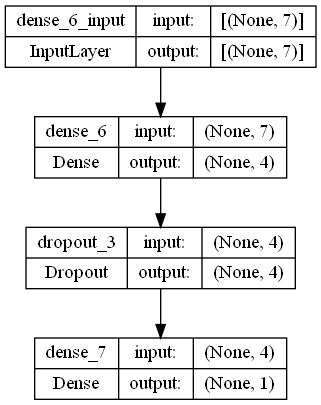

In [199]:
# examine structure
utils.plot_model(m1, show_shapes=True)

In [200]:
m1.compile(loss='mse',
           optimizer='adam',
           metrics=['mae'])

In [201]:
h1 = m1.fit(X_train,
                y_train, 
                batch_size=32,
                validation_data=(X_test, y_test),
                epochs=100,
                verbose=1)

Epoch 1/100
143/143 [==============================] - 2s 5ms/step - loss: 1309951.1250 - mae: 854.3697 - val_loss: 454314.0000 - val_mae: 674.0074
Epoch 2/100
143/143 [==============================] - 0s 2ms/step - loss: 562393.6250 - mae: 552.1833 - val_loss: 179014.6406 - val_mae: 423.0882
Epoch 3/100
143/143 [==============================] - 0s 2ms/step - loss: 250055.6875 - mae: 360.0918 - val_loss: 74319.0625 - val_mae: 272.6068
Epoch 4/100
143/143 [==============================] - 0s 2ms/step - loss: 127811.3438 - mae: 274.5950 - val_loss: 29976.2148 - val_mae: 173.1309
Epoch 5/100
143/143 [==============================] - 0s 2ms/step - loss: 71234.7734 - mae: 213.5461 - val_loss: 12399.5127 - val_mae: 111.3493
Epoch 6/100
143/143 [==============================] - 0s 2ms/step - loss: 45979.4727 - mae: 174.7856 - val_loss: 5868.8389 - val_mae: 76.6055
Epoch 7/100
143/143 [==============================] - 0s 2ms/step - loss: 33633.8203 - mae: 149.2840 - val_loss: 3167.6797 -

143/143 [==============================] - 0s 2ms/step - loss: 0.2377 - mae: 0.4061 - val_loss: 0.1059 - val_mae: 0.2931
Epoch 61/100
143/143 [==============================] - 0s 2ms/step - loss: 0.2224 - mae: 0.3880 - val_loss: 0.1047 - val_mae: 0.2920
Epoch 62/100
143/143 [==============================] - 0s 2ms/step - loss: 0.2147 - mae: 0.3815 - val_loss: 0.0953 - val_mae: 0.2766
Epoch 63/100
143/143 [==============================] - 0s 2ms/step - loss: 0.2141 - mae: 0.3791 - val_loss: 0.0838 - val_mae: 0.2575
Epoch 64/100
143/143 [==============================] - 0s 3ms/step - loss: 0.2144 - mae: 0.3798 - val_loss: 0.0955 - val_mae: 0.2783
Epoch 65/100
143/143 [==============================] - 0s 3ms/step - loss: 0.2053 - mae: 0.3693 - val_loss: 0.0917 - val_mae: 0.2732
Epoch 66/100
143/143 [==============================] - 0s 2ms/step - loss: 0.2055 - mae: 0.3675 - val_loss: 0.0910 - val_mae: 0.2733
Epoch 67/100
143/143 [==============================] - 0s 3ms/step - loss:

In [202]:
r2_score(y_test,m1.predict(X_test).ravel())

36/36 [==============================] - 0s 1ms/step


-6.968545195858738